# Siamese LSTM

In [20]:
import json
import datetime
import itertools
import pickle
import re
from time import time

import keras.backend as K
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from gensim import downloader
from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import tokenize
from keras.layers import Input, Embedding, LSTM, Lambda
from keras.models import Model, load_model
from keras.optimizers import Adadelta
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from spacy.tokenizer import Tokenizer

In [21]:
class WordLevelVectorization:
    """
    Represents WordLevelVectorization model

    :attr: train: bool
        train Word2Vec model
    :attr: n_neighbours: int
        number of similar documents
    :attr: metric: str
        metric to be used in KNN, e.g. "euclidean", "cityblock", "cosine"
    :attr: logging: bool
        log during execution
    :attr: word_vectors: str
        word vectors strategy, e.g. "custom" or "pretrained"
    :attr: strategy: str
        strategy of transforming word vectors to sentence vector, e.g. "sum", "average"
    :attr: weight: str
        weight type applied to word vector, e.g. "idf", "pos", "ner", "pos+ner"
    :attr: questions: np.ndarray
        input questions
    :attr: documents: list[list[str]]
        tokenized input questions
    :attr: wv: KeyedVectors
        word vectors
    :attr: nlp: spacy.lang.en.English
        spacy language
    """

    def __init__(
        self,
        train: bool = False,
        n_neighbours: int = 100,
        metric: str = "cosine",
        logging: bool = True,
        word_vectors: str = "custom",
        strategy: str = "sum",
        weight: str = None,
    ):
        """
        Initialize CustomWord2Vec class

        :param train: bool
            train Word2Vec model
        :param n_neighbours: int
            number of similar documents
        :param metric: str
            metric to be used in KNN, e.g. "euclidean", "cityblock", "cosine"
        :param logging: bool
            log during execution
        :param word_vectors: str
            word vectors strategy, e.g. "custom" or "pretrained"
        :param strategy: str
            strategy of transforming word vectors to sentence vector, e.g. "sum", "average"
        :param weight: str
            weight type applied to word vector, e.g. "idf", "pos", "ner", "pos+ner"
        """
        self.train = train
        self.n_neighbours = n_neighbours
        self.metric = metric
        self.logging = logging
        self.word_vectors = word_vectors
        self.strategy = strategy
        self.weight = weight

        df = pd.read_csv("../../data/traveling_qna_dataset.csv", sep="\t")
        df.drop(columns=df.columns[0], axis=1, inplace=True)
        self.questions = np.unique(df.iloc[:, 0].to_numpy())
        self.documents = [
            list(tokenize(question.lower())) for question in self.questions
        ]

        if self.train:
            _, self.wv = train_save_word2vec(self.documents)
            if self.logging:
                print("Word2Vec model trained and saved")
        else:
            if self.word_vectors == "custom":
                self.wv = KeyedVectors.load("../high_recall/word_level_vectorization/word2vec.wordvectors", mmap="r")
                if self.logging:
                    print("Custom Word2Vec model loaded")
            elif self.word_vectors == "pretrained":
                self.wv = downloader.load("glove-wiki-gigaword-50")
                for i, document in enumerate(self.documents):
                    self.documents[i] = list(
                        filter(lambda x: x in self.wv.index_to_key, document)
                    )
                if self.logging:
                    print("Pretrained Word2Vec model loaded")
            else:
                raise ValueError(
                    f"Word vectors {self.word_vectors} are not supported. Try 'custom' or 'pretrained'"
                )

        if weight == "idf":
            self.tfidf_vectorizer = TfidfVectorizer(token_pattern="(?u)\\b\\w+\\b")
            self.tfidf_vectorizer.fit_transform(
                [" ".join(question) for question in self.documents]
            )
        elif weight in ("pos", "ner", "pos+ner"):
            self.nlp = spacy.load("en_core_web_sm")
            self.nlp.tokenizer = Tokenizer(
                self.nlp.vocab, token_match=re.compile(r"\S+").match
            )

    def vectorize(self, document: list[str]) -> np.ndarray:
        """
        Transforms documents to vectors

        :param document:
            input document from corpus
        :return:
            vector representation of question
        """
        if self.weight == "idf":
            idf = np.asarray(
                [
                    self.tfidf_vectorizer.idf_[self.tfidf_vectorizer.vocabulary_[token]]
                    for token in document
                ]
            )
            document = np.asarray([self.wv[token] for token in document])
            document = idf[:, np.newaxis] * document
        elif self.weight == "pos":
            doc = self.nlp(" ".join(document))
            pos = np.asarray([POS.get(token.pos_, 1.0) for token in doc])

            document = np.asarray([self.wv[token] for token in document])
            document = pos[:, np.newaxis] * document
        elif self.weight == "ner":
            doc = self.nlp(" ".join(document))
            ner = np.asarray([NER.get(token.ent_type_, 1.0) for token in doc])

            document = np.asarray([self.wv[token] for token in document])
            document = ner[:, np.newaxis] * document
        elif self.weight == "pos+ner":
            doc = self.nlp(" ".join(document))
            pos = np.asarray([POS.get(token.pos_, 1.0) for token in doc])
            ner = np.asarray([NER.get(token.ent_type_, 1.0) for token in doc])
            pos_ner = pos + ner

            document = np.asarray([self.wv[token] for token in document])
            document = pos_ner[:, np.newaxis] * document
        else:
            document = np.asarray([self.wv[token] for token in document])

        if self.strategy == "sum":
            document = np.sum(document, axis=0)
        elif self.strategy == "average":
            document = np.mean(document, axis=0)
        else:
            raise ValueError(
                f"Strategy {self.strategy} is not supported. Try 'sum' or 'average'"
            )

        return document

    def check_performance(self, knn: NearestNeighbors) -> float:
        """
        Calculate performance of finding similar questions

        :param knn: NearestNeighbors
            K-nearest neighbors
        :return:
            score (lesser is better)
        """
        print("Performance check started")
        with open("../../data/test_questions_json.json") as json_file:
            json_data = json.load(json_file)

        test_questions = json_data["question"]
        original = json_data["original"]

        test_questions = [list(tokenize(tq.lower())) for tq in test_questions]
        for i, tq in enumerate(test_questions):
            test_questions[i] = list(filter(lambda x: x in self.wv.index_to_key, tq))
        test_questions = np.asarray([self.vectorize(tq) for tq in test_questions])
        _, indices = knn.kneighbors(test_questions)

        original = [list(tokenize(o.lower())) for o in original]
        indices_original = np.asarray([self.documents.index(o) for o in original])

        rank = np.where(indices == indices_original[:, None])[1]
        penalization = (indices_original.shape[0] - rank.shape[0]) * 2 * knn.n_neighbors
        score = (rank.sum() + penalization) / indices_original.shape[0]

        return score

    def get_n_similar_documents(self, document: str) -> list[str]:
        """
        Gives N documents similar to input document

        :param document: str
            input document
        :return:
            list of N documents similar to input document
        """
        start_time = time()

        vectorized_questions = np.asarray(
            [self.vectorize(question) for question in self.documents]
        )
        if self.logging:
            print("Questions vectorized")

        knn = NearestNeighbors(n_neighbors=self.n_neighbours, metric=self.metric).fit(
            vectorized_questions
        )
        if self.logging:
            print("KNN fitted")

        if self.logging:
            score = self.check_performance(knn)
            print(f"Score: {score:.2f} | ETA: {time() - start_time:.2f}s")

        document = tokenize(document.lower())
        document = list(filter(lambda x: x in self.wv.index_to_key, document))
        document = np.asarray(self.vectorize(document)).reshape(1, -1)

        _, indices = knn.kneighbors(document)

        similar_documents = [self.questions[i] for i in indices]
        similar_documents = similar_documents[0].tolist()

        return similar_documents

In [22]:
def text_to_word_list(text):
    """Preprocess and convert texts to a list of words"""
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

In [23]:
def exponent_neg_manhattan_distance(left, right):
    """Helper function for the similarity estimate of the LSTMs outputs"""
    return K.exp(-K.sum(K.abs(left - right), axis=1, keepdims=True))

In [24]:
def find_answer(question: str) -> str:
    df = pd.read_csv("../../data/traveling_qna_dataset.csv", sep="\t")
    df.drop(columns=df.columns[0], axis=1, inplace=True)
    answer = df.loc[df["Question"] == question]["Answer"].tolist()

    return " ".join(answer)

In [25]:
nltk.download("stopwords")

# File path
TRAIN_TSV = "../../data/quora_duplicate_questions.tsv"
WORD_VECTORS = "custom"  # word vectors strategy, e.g. "custom" or "pretrained"

# Load training set
train_df = pd.read_csv(TRAIN_TSV, delimiter="\t").iloc[:, 3:]

df = pd.read_csv("../../data/traveling_qna_dataset.csv", sep="\t")
df.drop(columns=df.columns[0], axis=1, inplace=True)
questions = np.unique(df.iloc[:, 0].to_numpy())
documents = [
    list(tokenize(question.lower())) for question in questions
]

stops = set(stopwords.words("english"))

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = [
    "<unk>"
]  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding

if WORD_VECTORS == "custom":
    word2vec = Word2Vec(
        sentences=documents, vector_size=100, window=5, min_count=1, workers=4, epochs=50
    ).wv
elif WORD_VECTORS == "pretrained":
    word2vec = downloader.load("word2vec-google-news-300")
else:
    raise ValueError(
        f"Word vectors {WORD_VECTORS} are not supported. Try 'custom' or 'pretrained'"
    )

questions_cols = ["question1", "question2"]

# Iterate over the questions only of training dataset
for index, row in train_df.iterrows():
    # Iterate through the text of both questions of the row
    for question in questions_cols:
        q2n = []  # q2n -> question numbers representation
        for word in text_to_word_list(row[question]):
            # Check for unwanted words
            if word in stops and word not in word2vec.key_to_index:
                continue

            if word not in vocabulary:
                vocabulary[word] = len(inverse_vocabulary)
                q2n.append(len(inverse_vocabulary))
                inverse_vocabulary.append(word)
            else:
                q2n.append(vocabulary[word])

        # Replace questions as word to question as number representation
        train_df.at[index, question] = q2n

if WORD_VECTORS == "custom":
    embedding_dim = 100
elif WORD_VECTORS == "pretrained":
    embedding_dim = 300

embeddings = 1 * np.random.randn(
    len(vocabulary) + 1, embedding_dim
)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.key_to_index:
        embeddings[index] = word2vec.get_vector(word)

del word2vec

max_seq_length = 212

print(f"Maximum sequence length: {max_seq_length}")

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df["is_duplicate"]

X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=validation_size
)

# Split to dicts
X_train = {"left": X_train.question1, "right": X_train.question2}
X_validation = {"left": X_validation.question1, "right": X_validation.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ["left", "right"]):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train["left"].shape == X_train["right"].shape
assert len(X_train["left"]) == len(Y_train)

# Model variables
n_hidden = 20
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 1

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype="int32")
right_input = Input(shape=(max_seq_length,), dtype="int32")

embedding_layer = Embedding(
    len(embeddings),
    embedding_dim,
    weights=[embeddings],
    input_length=max_seq_length,
    trainable=False,
)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(
    function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
    output_shape=lambda x: (x[0][0], 1),
)([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# # Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
# 
# malstm.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy"])
# 
# # Start training
# training_start_time = time()
# 
# malstm_trained = malstm.fit(
#     [X_train["left"], X_train["right"]],
#     Y_train,
#     batch_size=batch_size,
#     epochs=n_epoch,
#     validation_data=([X_validation["left"], X_validation["right"]], Y_validation),
# )
# 
# print(
#     "Training time finished.\n{} epochs in {}".format(
#         n_epoch, datetime.timedelta(seconds=time() - training_start_time)
#     )
# )
# 
# if WORD_VECTORS == "custom":
#     with open('../high_precision/vocabulary/vocabulary_custom_wv.pkl', 'wb') as f:
#         pickle.dump(vocabulary, f)
#     np.save("../high_precision/embeddings/custom_wv_embeddings.npy", embeddings)
#     malstm.save_weights("../high_precision/weights/malstm_weights_custom_wv.h5")
# elif WORD_VECTORS == "pretrained":
#     with open('../high_precision/vocabulary/vocabulary_pretrained_wv.pkl', 'wb') as f:
#         pickle.dump(vocabulary, f)
#     np.save("../high_precision/embeddings/pretrained_wv_embeddings.npy", embeddings)
#     malstm.save_weights("../high_precision/weights/malstm_weights_pretrained_wv.h5")
# 
# # Plot accuracy
# plt.plot(malstm_trained.history["accuracy"])
# plt.plot(malstm_trained.history["val_accuracy"])
# plt.title("Model Accuracy")
# plt.ylabel("Accuracy")
# plt.xlabel("Epoch")
# plt.legend(["Train", "Validation"], loc="upper left")
# plt.show()
# 
# # Plot loss
# plt.plot(malstm_trained.history["loss"])
# plt.plot(malstm_trained.history["val_loss"])
# plt.title("Model Loss")
# plt.ylabel("Loss")
# plt.xlabel("Epoch")
# plt.legend(["Train", "Validation"], loc="upper right")
# plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Milos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Maximum sequence length: 212


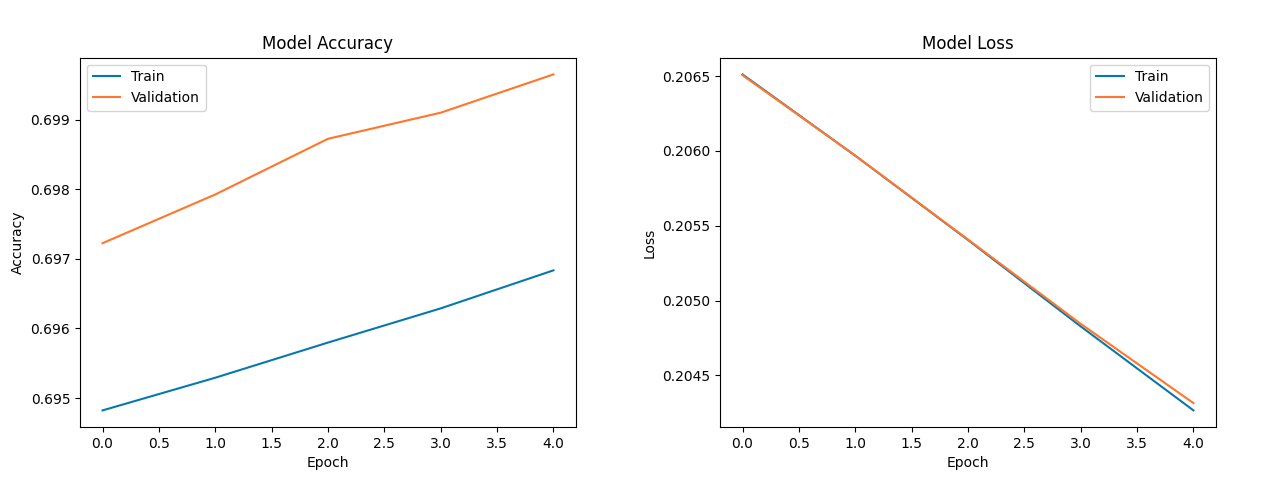

In [36]:
high_recall_model = WordLevelVectorization(
            train=False,
            n_neighbours=100,
            metric="cosine",
            logging=False,
            word_vectors="pretrained",
            strategy="sum",
            weight=None,
        )

In [45]:
test_question = "Can you fly aroun the world with just one bag?"

candidates = high_recall_model.get_n_similar_documents(test_question)
candidates_ = candidates.copy()
questions = [test_question for _ in range(len(candidates))]

for i, c in enumerate(candidates):
    candidates[i] = [
        vocabulary.get(word, 0)
        for word in text_to_word_list(c)
        if word not in stops
    ]
for i, q in enumerate(questions):
    questions[i] = [
        vocabulary.get(word, 0)
        for word in text_to_word_list(q)
        if word not in stops
    ]
candidates = pad_sequences(candidates, maxlen=212)
questions = pad_sequences(questions, maxlen=212)

In [46]:
malstm = load_model("model/malstm_model_pretrained_wv.h5", compile=False)
output = malstm.predict([questions, candidates])
output = list(itertools.chain.from_iterable(output))

index_max = np.argmax(output)
print(f"Maximum prediction is: {output[index_max]}")
print()
print("Question: " + test_question)
print()

if output[index_max] < 0.7:
    print("Answer: Sorry, but I do not understand your question. Can you rephrase it and try again?")
else:
    print("Answer: " + find_answer(candidates_[index_max]))

4/4 [==============================] - 1s 44ms/step
Maximum prediction is: 0.8065972924232483

Question: Can you fly aroun the world with just one bag?

Answer: Sure. It depends on the length of the trip, what you'll be doing, and where you'll be going.
My general rule is that, as long as I don't need bulky cold-weather gear or any special equipment, I can travel up to 10 days with a single bag... indefinitely if I can/want to do laundry. Stick with thinner, lightweight fabrics, and if possible, just one pair of shoes. Minimal toiletries are needed if you're staying in decent hotels, or you can just buy what you need on the road. at the lower end anyway, the limit on checked luggage is 20 kgs and on carry on is about 5. It can be much more at the higher end. You can easily pack nearly everything you need to travel to most places in those bags, plus the clothes on your body, especially as in cold weather people now wear down a lot, plus layering with thermal inner layers.
There is no re